<a href="https://colab.research.google.com/github/R0bk/ml_replications/blob/main/05_vqvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VQVAE

In [ ]:
!pip install torch torchvision
!pip install numpy tqdm

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Resize
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()#Compose([ToTensor(), Resize((32, 32))])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 1, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


In [ ]:
data_variance = torch.var(training_data.data / 255.0)
print(data_variance)

tensor(0.1246)


In [ ]:
class VectorQuantizerEMA(nn.Module):
  def __init__(self, n_embed, embed_dim, decay=0.99, eps=1e-5, beta=0.25):
    super(VectorQuantizerEMA, self).__init__()
    self.n_embed = n_embed
    self.embed_dim = embed_dim
    self.decay = decay
    self.eps = eps
    self.commitment_cost = beta

    self.register_buffer('embeddings', torch.rand(embed_dim, n_embed))
    self.register_buffer('cluster_size', torch.zeros(n_embed))
    self.register_buffer('embed_avg', self.embeddings.clone())

  def forward(self, x):
    # convert inputs from N*X_1*X_2...X_n -> -1*EmbedDim
    x = x.permute(0, 2, 3, 1).contiguous()
    flat_inputs = x.view(-1, self.embed_dim)

    distances = (
        flat_inputs.pow(2).sum(1, keepdims=True) -
        2 * flat_inputs.mm(self.embeddings) +
        self.embeddings.pow(2).sum(0, keepdims=True))

    encoding_indices = torch.argmin(distances, 1)
    encoding = F.one_hot(encoding_indices, self.n_embed)

    encoding_indices = encoding_indices.view(x.shape[:-1])
    quantized = self.embeddings.t().index_select(0, encoding_indices.view(-1)).view(x.shape)

    latent_loss = F.mse_loss(quantized.detach(), x)
    commitment_loss = latent_loss * self.commitment_cost

    if self.training:
      self.cluster_size.data.mul_(self.decay).add_(1 - self.decay, encoding.sum(0))
      
      n = self.cluster_size.data.sum()
      cluster_size = (
          (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
      )

      # Goal here is to calculate the average of the inputs w.r.t each encoding
      embed_sum = flat_inputs.t() @ encoding.type_as(x)
      self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
      self.embeddings.data = self.embed_avg / cluster_size.unsqueeze(0)

    # pass through grad to encoder
    quantized = x + quantized.detach() - x.detach()

    avg_probs = encoding.type_as(flat_inputs).mean(0)
    perplexity = (-(avg_probs * avg_probs.add(1e-10).log()).sum()).exp()
    return quantized.permute(0, 3, 1, 2), commitment_loss, perplexity

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


class NeuralNetwork(nn.Module):
  def __init__(self, latent_size=40, embed_size=30, embed_dim=40):
    super(NeuralNetwork, self).__init__()
    self.latent_size = latent_size
    self.embed_size = embed_size
    self.embed_dim = embed_dim
    self.flatten = nn.Flatten()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 400),
        nn.ReLU(),
        nn.Linear(400, 64),
        nn.ReLU(),
        nn.Linear(64, latent_size),
    )
    self.ema = VectorQuantizerEMA(embed_size, embed_dim)
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 64),
        nn.ReLU(),
        nn.Linear(64, 400),
        nn.ReLU(),
        nn.Linear(400, 28*28),
        nn.ReLU()
    )

  def calculate_loss(self, x, com_loss, z_e, z_q, recon_x):
    vq_loss = F.mse_loss(z_q, z_e.detach())
    recon_loss = F.mse_loss(x, recon_x)
    # print(z_e, z_q)
    # print(recon_loss, vq_loss, com_loss)
    return recon_loss + com_loss

  def forward(self, x):
    x = self.flatten(x)
    z_e = self.encoder(x)
    z_q, com_loss = self.ema(z_e)
    recon_x = self.decoder(z_q)
    loss = self.calculate_loss(x, com_loss, z_e, z_q, recon_x)
    return recon_x, loss

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=40, bias=True)
  )
  (ema): VectorQuantizerEMA()
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): ReLU()
  )
)


In [ ]:
class ResidualStack(nn.Module):
  def __init__(self, in_channels, num_hidden, num_residual_layers, num_residual_hidden):
    super(ResidualStack, self).__init__()
    self.in_channels = in_channels
    self.num_hidden = num_hidden
    self.num_residual_layers = num_residual_layers
    self.num_residual_hidden = num_residual_hidden

    self.layers = nn.ModuleList([nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(in_channels=in_channels, out_channels=num_residual_hidden, kernel_size=3, stride=1, padding=1,),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_residual_hidden, out_channels=num_hidden, kernel_size=1, stride=1)
    ) for i in range(self.num_residual_layers)])

  def forward(self, h):
    for res in self.layers:
      h = h + res(h)
    return F.relu(h)

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, embed_size=512, embed_dim=64, num_hidden=128, num_residual_layers=2, num_residual_hidden=32, data_variance=1.):
        super(VQVAE, self).__init__()
        self.embed_size = embed_size
        self.embed_dim = embed_dim
        self.num_hidden = num_hidden
        self.num_residual_layers = num_residual_layers
        self.num_residual_hidden = num_residual_hidden

        self._data_variance = data_variance


        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=num_hidden//2, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_hidden//2, out_channels=num_hidden, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_hidden, out_channels=num_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            ResidualStack(num_hidden, num_hidden, num_residual_layers, num_residual_hidden)
        )

        self.pre_vq = nn.Conv2d(in_channels=num_hidden, out_channels=embed_dim, kernel_size=1, stride=1)

        self.vq_ema = VectorQuantizerEMA(embed_size, embed_dim)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=embed_dim, out_channels=num_hidden, kernel_size=1, stride=1),
            ResidualStack(num_hidden, num_hidden, num_residual_layers, num_residual_hidden),
            nn.ConvTranspose2d(in_channels=num_hidden, out_channels=num_hidden//2, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=num_hidden//2, out_channels=1, kernel_size=6, stride=2)
        )

    def calculate_loss(self, x, com_loss, z_e, z_q, recon_x):
        vq_loss = F.mse_loss(z_q, z_e.detach())
        recon_loss = F.mse_loss(x, recon_x) / self._data_variance
        # print(z_e, z_q)
        # print(recon_loss, vq_loss, com_loss)
        return recon_loss + com_loss

    def forward(self, x):
        z_e = self.pre_vq(self.encoder(x))
        z_q, com_loss, perplexity = self.vq_ema(z_e)
        recon_x = self.decoder(z_q)
        loss = self.calculate_loss(x, com_loss, z_e, z_q, recon_x)
        return recon_x, loss, perplexity

model = VQVAE(data_variance=data_variance).to(device)
print(model)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ResidualStack(
      (layers): ModuleList(
        (0): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (pre_vq): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (vq_ema): VectorQuantizerEMA()
  (decoder): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ResidualSta

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        # print(n, p)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [ ]:
def train(dataloader, model, optimiser):
  size = len(train_dataloader.dataset)

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred, loss, perplexity = model(X)
    # print(pred)
    # print(loss)
    # print(perplexity)

    optimiser.zero_grad()
    loss.backward()
    # plot_grad_flow(model.named_parameters())
    optimiser.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} perplexity: {perplexity:>7f} [{current:>5d}/{size:>5d}]")
    # break

In [ ]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimiser)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)


loss: 0.315461 perplexity: 1.999436 [    0/60000]
loss: 0.053992 perplexity: 1.814628 [12800/60000]
loss: 0.060387 perplexity: 1.645085 [25600/60000]
loss: 0.068367 perplexity: 1.394549 [38400/60000]
loss: 0.079325 perplexity: 1.255867 [51200/60000]
Epoch 2
-------------------------------
loss: 0.071450 perplexity: 1.354267 [    0/60000]
loss: 0.062066 perplexity: 1.431541 [12800/60000]
loss: 0.079861 perplexity: 1.337516 [25600/60000]
loss: 0.074025 perplexity: 1.304211 [38400/60000]
loss: 0.133104 perplexity: 1.250463 [51200/60000]
Epoch 3
-------------------------------
loss: 0.089776 perplexity: 1.344446 [    0/60000]
loss: 0.080185 perplexity: 1.243937 [12800/60000]
loss: 0.068397 perplexity: 1.558607 [25600/60000]
loss: 0.034854 perplexity: 2.576520 [38400/60000]
loss: 0.027267 perplexity: 4.746062 [51200/60000]
Epoch 4
-------------------------------
loss: 0.024575 perplexity: 8.165730 [    0/60000]
loss: 0.020874 perplexity: 11.970277 [12800/60000]
loss: 0.020138 perplexity: 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


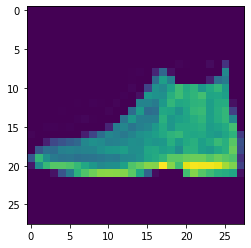

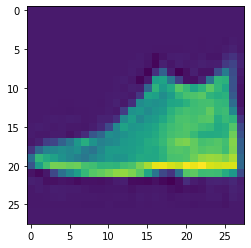

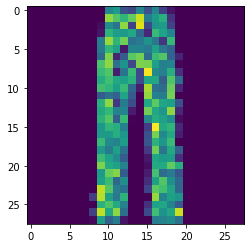

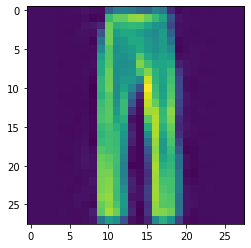

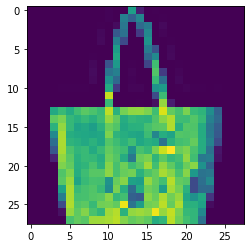

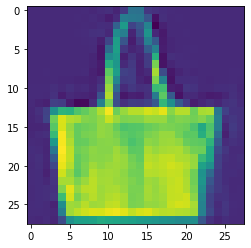

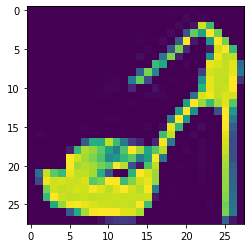

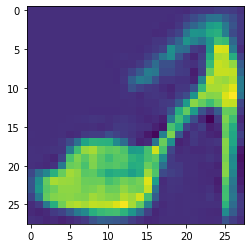

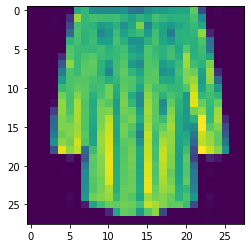

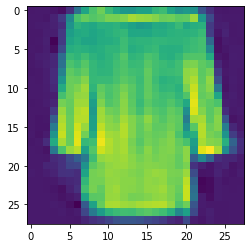

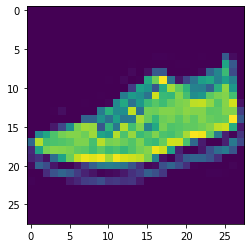

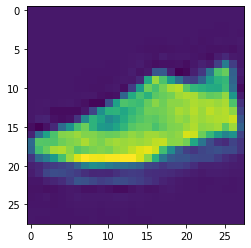

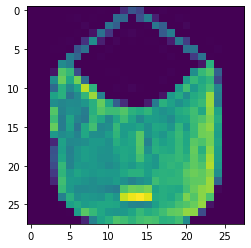

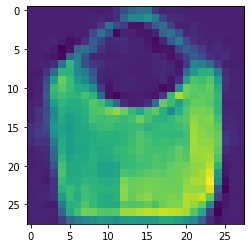

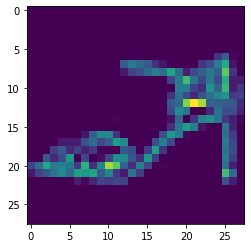

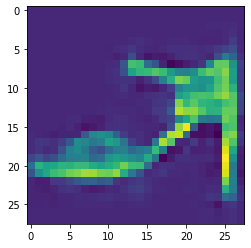

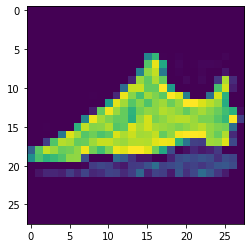

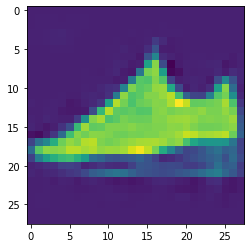

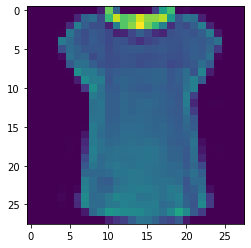

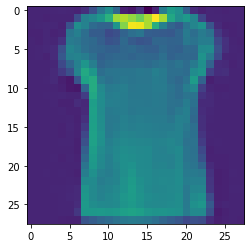

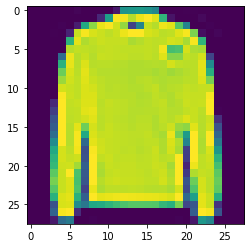

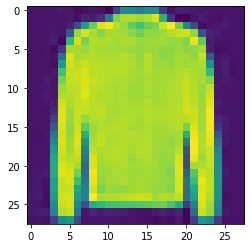

In [ ]:
def plot(dataloader, model):
    i = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            i += 1
            # print(X)
            X, y = X.to(device), y.to(device)
            pred, loss, perplexity = model(X)
            # print(pred)
            plt.figure()
            plt.imshow(  X.cpu()[0].squeeze()  )
            plt.figure()
            plt.imshow(  pred.cpu()[0][0]  )
            if i > 10:
              break
plot(test_dataloader, model)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
|!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward0>)


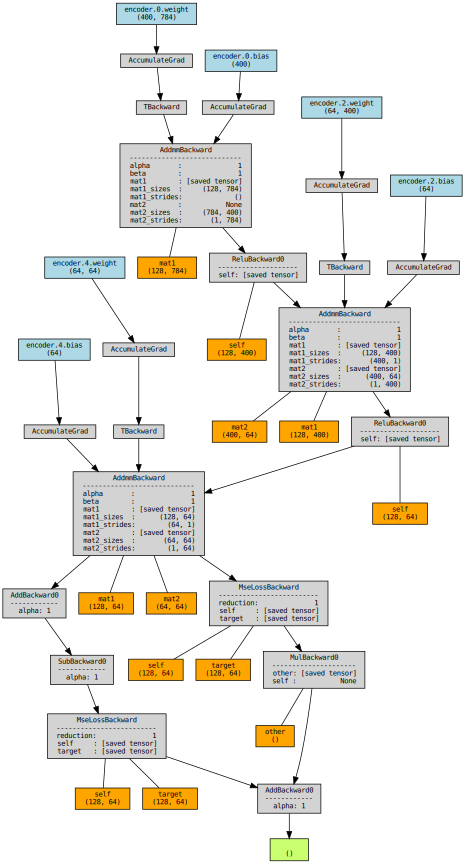

In [ ]:
from torchviz import make_dot, make_dot_from_trace
model.eval()
# with torch.no_grad():
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    x, pred, loss = model(X)
    print(pred)
    break
make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

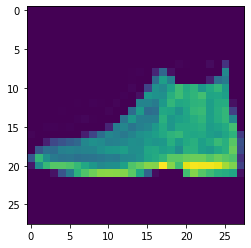

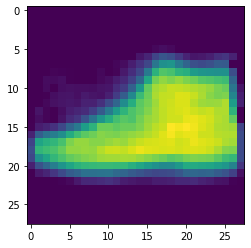

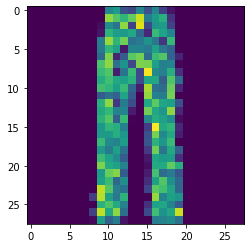

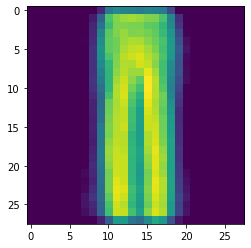

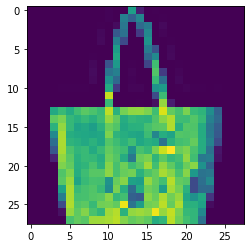

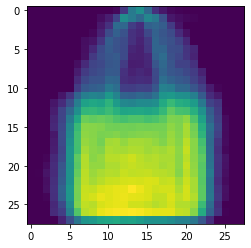

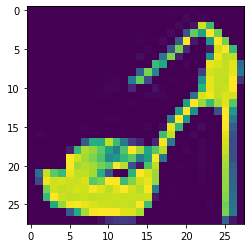

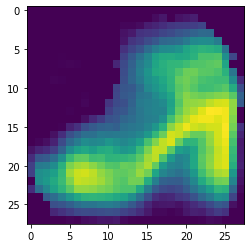

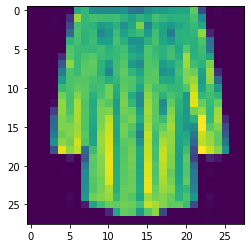

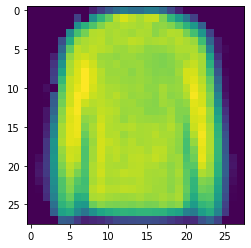

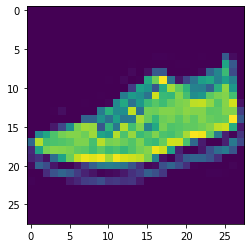

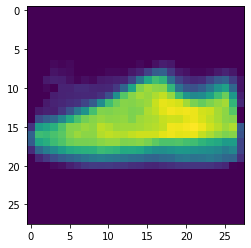

In [ ]:
def plot(dataloader, model):
    i = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            i += 1
            print(X)
            X, y = X.to(device), y.to(device)
            pred, loss = model(X)
            print(pred)
            plt.figure()
            plt.imshow(  X.cpu()[0].squeeze()  )
            plt.figure()
            plt.imshow(  pred.cpu().unflatten(1, torch.Size([28, 28]))[0]  )
            if i > 5:
              break
plot(test_dataloader, model)

## Refrences for implementation for for checking correctness

https://arxiv.org/abs/1711.00937

https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
https://colab.research.google.com/gist/tomhennigan/62edee62a4638e0d0ab9738a757043ed/tf2_vq_vae_training_example.ipynb#scrollTo=cIRl2ZtxoKNz
https://github.com/nadavbh12/VQ-VAE/blob/master/main.py
https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=-uqLy_taUUbI
https://github.com/MishaLaskin/vqvae